In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

%matplotlib inline

In [2]:
# Read in data
data_path = os.path.join('..', 'data', 'ablation_stakes')

filenames = ['ablation-contrasts-r2a-20250715.xlsx',
             'ablation-contrasts-r2b-20250801.xlsx',
             'ablation-contrasts-r2c-20250812.xlsx',
             'ablation-contrasts-r2d-20250823.xlsx',
             'ablation-contrasts-r3a-20250721.xlsx',
             'ablation-contrasts-r3b-20250806.xlsx',
             'ablation-contrasts-r3c-20250816.xlsx',
             'ablation-contrasts-r3d-20250826.xlsx',
            ]

ls_df = []
for filename in filenames:
    file_path = os.path.join(data_path, filename)
    ls_df.append(pd.read_excel(file_path, header=2))
    datestr = pd.read_excel(file_path, index_col=None, usecols = "B", header=1, nrows=0).columns.values[0]
    ls_df[-1]['datestr'] = datestr

df = pd.concat(ls_df)

In [3]:
df.shape

(76, 13)

In [4]:
# Create date column
df['date'] = pd.to_datetime(df['datestr'].astype('str'), format='%Y%m%d')
df = df.sort_values('Line')

In [5]:
df.groupby(by=['Line', 'date'])[['Hi (including SSL) (cm)']].mean().sort_index(level='Line')

Hi (including SSL) (cm)
Line           date                               
Maintransect_3 2025-07-21               243.000000
               2025-08-06               227.500000
               2025-08-18               215.125000
               2025-08-26               214.000000
albedo_2       2025-07-15                74.200000
               2025-08-01                37.428571
raftedice_2    2025-07-15               144.833333
               2025-08-01               129.666667
               2025-08-12               113.000000
               2025-08-24                84.833333

In [7]:
line = 'raftedice_2'

df_rate = df.query('Line == @line')[['Position', 'Hi (including SSL) (cm)', 'Ablation (cm)', 'date']]
df_rate = df_rate.pivot(index='date', columns='Position').reset_index()
df_rate['end'] = df_rate['date']
ls = [pd.NaT]
for date in df_rate['date'].values[:-1]:
    ls.append(date)
df_rate['start'] = ls
df_rate.set_index(['start', 'end'], inplace=True)
df_rate = df_rate.diff()
for column in df_rate.columns[1:]:
    df_rate[column] = df_rate[column]/df_rate[('date', '')].dt.days

df_rate = df_rate.drop(columns=('date', '')).iloc[1:]
df_rate_mean = df_rate.groupby(level=0, axis=1).mean()
df_rate_sem = df_rate.groupby(level=0, axis=1).sem()
df_rate_mean = df_rate_mean.rename(columns={'Ablation (cm)': 'surface_cm_d',
                             'Hi (including SSL) (cm)': 'total_cm_d',
                             })
df_rate_sem = df_rate_sem.rename(columns={'Ablation (cm)': 'surface_cm_d',
                             'Hi (including SSL) (cm)': 'total_cm_d',
                             })
# Surface melt cannot be negative
df_rate_mean['surface_cm_d'][df_rate_mean['surface_cm_d'] < 0] = 0

df_rate_mean['basal_cm_d'] = -1*df_rate_mean['total_cm_d'] - df_rate_mean['surface_cm_d']
df_rate_sem['basal_cm_d'] = np.sqrt(df_rate_sem['total_cm_d']**2 + df_rate_sem['surface_cm_d']**2)

df_rate_mean = df_rate_mean.reset_index()
df_rate_mean['date'] = (df_rate_mean['end'] - df_rate_mean['start'])/2 + df_rate_mean['start']
df_rate_sem = df_rate_sem.reset_index()
df_rate_sem['date'] = (df_rate_sem['end'] - df_rate_sem['start'])/2 + df_rate_sem['start']

df_ri_mean = df_rate_mean.copy()
df_ri_sem = df_rate_sem.copy()

In [8]:
line = 'Maintransect_3'

df_rate = df.query('Line == @line')[['Position', 'Hi (including SSL) (cm)', 'Ablation (cm)', 'date']]
df_rate = df_rate.pivot(index='date', columns='Position').reset_index()
df_rate['end'] = df_rate['date']
ls = [pd.NaT]
for date in df_rate['date'].values[:-1]:
    ls.append(date)
df_rate['start'] = ls
df_rate.set_index(['start', 'end'], inplace=True)
df_rate = df_rate.diff()
for column in df_rate.columns[1:]:
    df_rate[column] = df_rate[column]/df_rate[('date', '')].dt.days

df_rate = df_rate.drop(columns=('date', '')).iloc[1:]
df_rate_mean = df_rate.groupby(level=0, axis=1).mean()
df_rate_sem = df_rate.groupby(level=0, axis=1).sem()
df_rate_mean = df_rate_mean.rename(columns={'Ablation (cm)': 'surface_cm_d',
                             'Hi (including SSL) (cm)': 'total_cm_d',
                             })
df_rate_sem = df_rate_sem.rename(columns={'Ablation (cm)': 'surface_cm_d',
                             'Hi (including SSL) (cm)': 'total_cm_d',
                             })

# Surface melt cannot be negative
df_rate_mean['surface_cm_d'][df_rate_mean['surface_cm_d'] < 0] = 0

df_rate_mean['basal_cm_d'] = -1*df_rate_mean['total_cm_d'] - df_rate_mean['surface_cm_d']
df_rate_sem['basal_cm_d'] = np.sqrt(df_rate_sem['total_cm_d']**2 + df_rate_sem['surface_cm_d']**2)

df_rate_mean = df_rate_mean.reset_index()
df_rate_mean['date'] = (df_rate_mean['end'] - df_rate_mean['start'])/2 + df_rate_mean['start']
df_rate_sem = df_rate_sem.reset_index()
df_rate_sem['date'] = (df_rate_sem['end'] - df_rate_sem['start'])/2 + df_rate_sem['start']


In [9]:
# functions for secondary y axis, cm per day to W/m2

def melt_to_flux(x):
    rho = 880 # estimated bulk density kg/m3
    L_f = 334 # kJ/kg
    return x * (L_f) * (rho) * 1000.0 /(100 * 24 *3600)

def flux_to_melt(x):
    rho = 880.0 # estimated bulk density kg/m3
    L_f = 334.0 # kJ/kg
    return x * (1/L_f) * (1/rho) * 100 * 24 *3600/1000.0

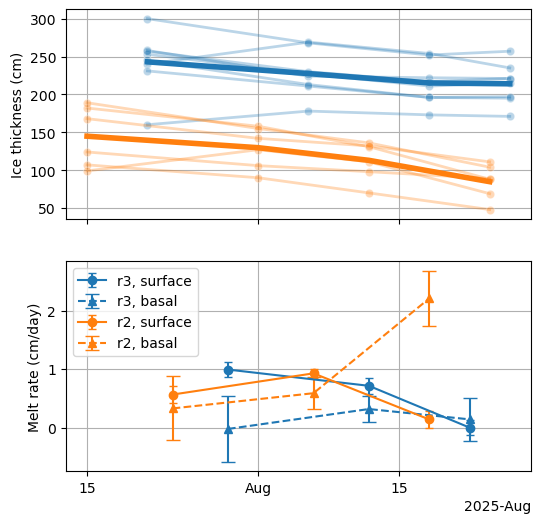

In [11]:
lines = 'raftedice_2', 'Maintransect_3'
df_temp = df.query('Line in @lines')

f, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 6))

sns.lineplot(x='date', y='Hi (including SSL) (cm)', hue='Line', size='Position', sizes=(2,2.00001), 
             data=df_temp, legend=False, marker='o', alpha=0.3, ax=axs[0])

sns.lineplot(x='date', y='Hi (including SSL) (cm)', hue='Line', legend=False, ax=axs[0],
             data=df_temp.groupby(by=['Line', 'date'])[['Hi (including SSL) (cm)']].mean(),
            linewidth=4, markersize=4)
axs[0].grid()
axs[0].set_ylabel('Ice thickness (cm)')

axs[1].errorbar(x=df_rate_mean.date, y=df_rate_mean.surface_cm_d, yerr=df_rate_sem.surface_cm_d,
               marker='o', ls='-', c='tab:blue', label='r3, surface', capsize=3)
axs[1].errorbar(x=df_rate_mean.date, y=df_rate_mean.basal_cm_d, yerr=df_rate_sem.basal_cm_d,
               marker='^', ls='--', c='tab:blue', label='r3, basal', capsize=5)

axs[1].errorbar(x=df_ri_mean.date, y=df_ri_mean.surface_cm_d, yerr=df_ri_sem.surface_cm_d,
               marker='o', ls='-', c='tab:orange', label='r2, surface', capsize=3)
axs[1].errorbar(x=df_ri_mean.date, y=df_ri_mean.basal_cm_d, yerr=df_ri_sem.basal_cm_d,
               marker='^', ls='--', c='tab:orange', label='r2, basal', capsize=5)
axs[1].legend()
axs[1].grid()
axs[1].set_ylabel('Melt rate (cm/day)')
#secy = axs[1].secondary_yaxis('right', functions=(melt_to_flux, flux_to_melt))
#secy.set_ylabel(r'Implied flux (W/m$^2$)')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

f.savefig(os.path.join('..', 'figures', '2.2.1_ablation_stakes.png'),
         dpi=300, bbox_inches='tight')

In [195]:
melt_to_flux(df_rate_mean.basal_cm_d)

0    -0.797309
1    10.782655
2     4.783854
Name: basal_cm_d, dtype: float64

In [196]:
melt_to_flux(df_rate_sem.basal_cm_d)

0    18.980549
1     7.314658
2    12.355515
Name: basal_cm_d, dtype: float64

In [197]:
melt_to_flux(df_rate_mean.surface_cm_d)

0    33.752749
1    24.298942
2     0.000000
Name: surface_cm_d, dtype: float64

In [198]:
melt_to_flux(df_rate_sem.surface_cm_d)

0    4.125855
1    4.623425
2    4.324028
Name: surface_cm_d, dtype: float64

In [181]:
df_ri_mean

,start,end,surface_cm_d,total_cm_d,basal_cm_d,date
0,2025-07-15,2025-08-01,0.564706,-0.892157,0.327451,2025-07-23 12:00:00
1,2025-08-01,2025-08-12,0.927273,-1.515152,0.587879,2025-08-06 12:00:00
2,2025-08-12,2025-08-24,0.138889,-2.347222,2.208333,2025-08-18 00:00:00


In [199]:
melt_to_flux(df_ri_mean.surface_cm_d)

0    19.210458
1    31.544444
2     4.724794
Name: surface_cm_d, dtype: float64

In [182]:
df_rate_mean

,start,end,surface_cm_d,total_cm_d,basal_cm_d,date
0,2025-07-21,2025-08-06,0.992188,-0.968750,-0.023438,2025-07-29
1,2025-08-06,2025-08-18,0.714286,-1.031250,0.316964,2025-08-12
2,2025-08-18,2025-08-26,0.000000,-0.140625,0.140625,2025-08-22


In [200]:
df_temp.groupby(by=['Line', 'date'])[['Hi (including SSL) (cm)']].mean()

Hi (including SSL) (cm)
Line           date                               
Maintransect_3 2025-07-21               243.000000
               2025-08-06               227.500000
               2025-08-18               215.125000
               2025-08-26               214.000000
raftedice_2    2025-07-15               144.833333
               2025-08-01               129.666667
               2025-08-12               113.000000
               2025-08-24                84.833333

In [130]:
line = 'raftedice_2'

df_rate = df.query('Line == @line')[['Position', 'Hi (including SSL) (cm)', 'Ablation (cm)', 'date']]
df_rate = df_rate.pivot(index='date', columns='Position').reset_index()
df_rate['end'] = df_rate['date']
ls = [pd.NaT]
for date in df_rate['date'].values[:-1]:
    ls.append(date)
df_rate['start'] = ls
df_rate.set_index(['start', 'end'], inplace=True)
df_rate = df_rate.diff()
for column in df_rate.columns[1:]:
    df_rate[column] = df_rate[column]/df_rate[('date', '')].dt.days

df_rate = df_rate.drop(columns=('date', '')).iloc[1:]
df_rate_mean = df_rate.groupby(level=0, axis=1).mean()
df_rate_sem = df_rate.groupby(level=0, axis=1).sem()
df_rate_mean = df_rate_mean.rename(columns={'Ablation (cm)': 'surface_cm_d',
                             'Hi (including SSL) (cm)': 'total_cm_d',
                             })
df_rate_sem = df_rate_sem.rename(columns={'Ablation (cm)': 'surface_cm_d',
                             'Hi (including SSL) (cm)': 'total_cm_d',
                             })
df_rate_mean['basal_cm_d'] = -1*df_rate_mean['total_cm_d'] - df_rate_mean['surface_cm_d']
df_rate_sem['basal_cm_d'] = np.sqrt(df_rate_sem['total_cm_d']**2 + df_rate_sem['surface_cm_d']**2)

df_rate_mean = df_rate_mean.reset_index()
df_rate_mean['date'] = (df_rate_mean['end'] - df_rate_mean['start'])/2 + df_rate_mean['start']
df_rate_sem = df_rate_sem.reset_index()
df_rate_sem['date'] = (df_rate_sem['end'] - df_rate_sem['start'])/2 + df_rate_sem['start']


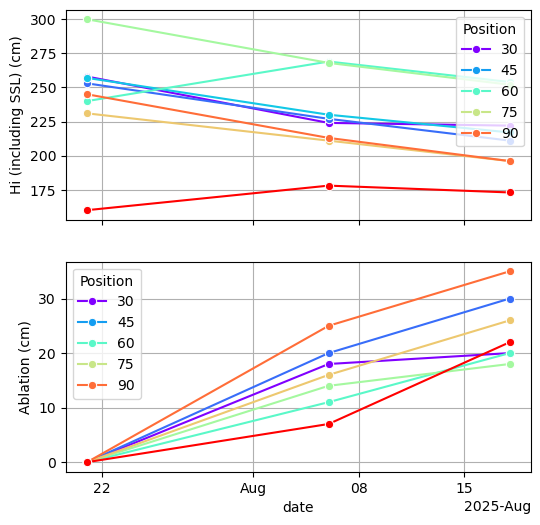

In [19]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 6))

sns.lineplot(x='date', y='Hi (including SSL) (cm)', hue='Position', data=df, ax=axs[0], palette='rainbow', marker='o')
axs[0].grid()

sns.lineplot(x='date', y='Ablation (cm)', hue='Position', data=df.query('Position != 50'), ax=axs[1], palette='rainbow', marker='o')

axs[1].grid()

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

In [26]:
df.query('Position != 50').groupby('date').mean(numeric_only=True)

,Position,Hi (including SSL) (cm),Draft (cm),SSL (cm),Pond Depth (cm),False Bottom depth (cm),Ablation (cm),datestr
date,,,,,,,,
2025-07-21,67.142857,241.000000,209.428571,NaN,0.000000,NaN,0.000000,20250721.0
2025-08-06,67.142857,227.142857,210.857143,3.0,0.285714,NaN,15.857143,20250806.0
2025-08-18,67.142857,214.857143,196.714286,3.6,1.000000,206.0,24.428571,20250818.0


In [27]:
227.14 - 214.86

12.279999999999973

In [24]:
24.4-15.9

8.499999999999998